In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-darkgrid")
plt.close('all')

$$\begin{align}    \frac{\partial C}{\partial y^{(k)}} &= \frac{\partial C}{\partial y^{(k+1)}}\,\nabla \sigma_{k+1}\,W^{(k+1)} \\    \frac{\partial C}{\partial W^{(k)}} &= y^{(k-1)}\,\frac{\partial C}{\partial y^{(k)}}\,\nabla \sigma_k\\    \frac{\partial C}{\partial b^{(k)}} &= \frac{\partial C}{\partial y^{(k)}}\, \nabla \sigma_k\end{align}$$

In [ ]:
class NeuralNet:
    def __init__(self, layers, lower_norm=1e-4,
                 upper_norm=1e+10, sigma_type='sinh'):
        # length of the list must be at least two
        self.layers = layers # e.g. [1, 5, 5, 1]
        self.depth = len(layers)
        self.W = [0] # list of weights between layers
        self.b = [0]
        self.dC_dy = [] # gradients of activations
        self.lr = 0.5
        self.y = []
        self.nabla_sigma = []
        self.sigma_type = sigma_type
        self.lower_norm = lower_norm
        self.upper_norm = upper_norm
        
        # creating weights and biases, note that self.W[0] is never used
        for k in range(1, self.depth):
            self.W.append(2 * np.random.rand(layers[k], layers[k-1]) - 1)
            self.b.append(2 * np.random.rand(layers[k], 1) - 1) # column vector
            
        # creating outputs and derivative holders
        for k in range(self.depth):
            self.y.append(np.zeros((self.layers[k], 1))) # column vector
            self.nabla_sigma.append(np.zeros((self.layers[k], self.layers[k])))
            self.dC_dy.append(np.zeros((1, self.layers[k]))) # row vector 
        
        return 
        
    def cost(self, x_train, y_train):
        ''' global cost evaluated for a training set '''
        s = 0
        for idx, x in enumerate(x_train):
            self.forward_pass(x)
            s += np.linalg.norm(self.y[-1] - y_train[idx]) ** 2
        s *= 1 / (2 * len(x_train))
        return s
    
    def cost_derivative(self, y, y_train):
        ''' gradient in the last layer of the network '''
        return (y - y_train).T # row vector 
    
    def sigma(self, x):
        ''' all layers have the same activation function '''
        if self.sigma_type == 'relu':
            return np.maximum(x, 0)
        elif self.sigma_type == 'tanh':
            return np.tanh(x)
        else:
            return 1 / (1 + np.exp(-x))
            
    def sigma_derivative(self, x):
        ''' derivative of the sigma function 
        in terms of sigma function itself '''
        if self.sigma_type == 'relu':
            return x >= 0 # elementwise compare with zero
        elif self.sigma_type == 'tanh':
            return 1 - np.square(x) # elementwise square
        else:
            return np.multiply(1-x, x) # elementwise multiplication
    
    def forward_pass(self, x):
        self.y[0] = np.matrix(x) # setting the input
        for k in range(1, self.depth):
            self.y[k] = self.sigma(self.W[k] @ self.y[k-1] + self.b[k])
            self.nabla_sigma[k] = np.diagflat(self.sigma_derivative(self.y[k]))
        return 
            
    def backward_pass(self, y_train):
        # base case
        self.dC_dy[-1] = self.cost_derivative(self.y[-1], y_train) 
        
        for k in range(1, self.depth):
            
            # clip
            self.dC_dy[-k] = self.clip(self.dC_dy[-k])
            
            # first equation
            self.dC_dy[-1-k] = self.dC_dy[-k] @ self.nabla_sigma[-k] @ self.W[-k]
            
            # second equation
            self.W[-k] += - self.lr * (self.y[-1-k] @ (self.dC_dy[-k] @ self.nabla_sigma[-k])).T
            
            # third equation
            self.b[-k] += - self.lr * (self.dC_dy[-k] @ self.nabla_sigma[-k]).T
  
            

        return 
    
    def evaluate(self, x):
        self.forward_pass(x)
        return self.y[-1]
    
    def train(self, x_train, y_train, iterations=1e+5, 
              adaptive_lr=False, verbose=False):
        n_data = len(x_train) # stochastic gradient descent
        for epoch in tqdm(range(int(iterations))):
            if adaptive_lr:
                nn.lr = min(1 / np.sqrt(epoch + 1), 1e-2)
            
            idx = np.random.randint(n_data)
            
            self.forward_pass(x_train[idx])
            
            nn.backward_pass(y_train[idx])
            
            if verbose and epoch % 1000 == 0:
                print(f'Iteration {epoch}')
                print(f'cost = {self.cost(x_train, y_train):.2e}')
                print('======================================================')
            
    def clip(self, gradient):
        grad_norm = np.linalg.norm(gradient)
        if grad_norm / gradient.size < self.lower_norm and grad_norm > 1e-10:
            gradient *= self.lower_norm / grad_norm
        elif grad_norm / gradient.size > self.upper_norm:
            gradient *= self.upper_norm / grad_norm
        return gradient

100%|██████████| 100000/100000 [00:46<00:00, 2142.57it/s]


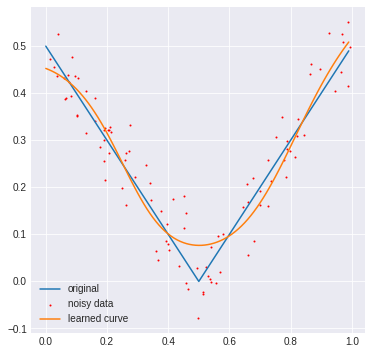

In [ ]:
x_points = np.arange(0, 1, 0.01) # underlying function x-values for evaluation
y_points = np.abs(x_points - 0.5) # underlying function y-values for evaluation

# generate data
mu, sigma = 0, 0.05 # mean and standard deviation
n_data = 100 # number of data points
s = np.random.normal(mu, sigma, n_data) # generate noise
x_data_points = np.random.uniform(size=n_data) # training data x-values
y_data_points = np.abs(x_data_points - 0.5) + s # training data y-values

# initialize the net
nn = NeuralNet([1, 5, 5, 1], sigma_type='sigmoid') # two-hidden layers

# train the net
nn.train(x_data_points, y_data_points)

# evaluate
y_test = np.zeros(len(x_points))
for i in range(len(x_points)):
    y_test[i] = nn.evaluate(x_points[i]) # approximate the function with forward mode

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x_points, y_points, label='original')
ax.scatter(x_data_points, y_data_points, label='noisy data', c='r', s=1)
ax.plot(x_points, y_test, label='learned curve')
ax.legend()

100%|██████████| 100000/100000 [00:39<00:00, 2513.14it/s]


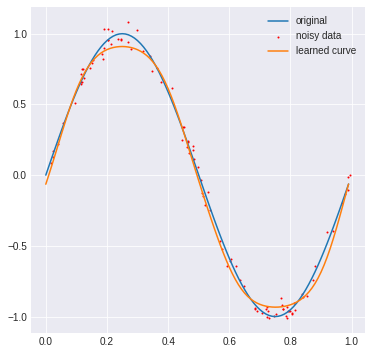

In [ ]:
x_points = np.arange(0, 1, 0.01)
y_points = np.sin(2*np.pi*(0.5 - x_points))

# generate data
s = np.random.normal(mu, sigma, n_data)
x_data_points = np.random.uniform(size=n_data)
y_data_points = np.sin(2*np.pi*(0.5-x_data_points)) + s

# initialize the net
nn = NeuralNet([1, 30, 30, 1], sigma_type='tanh')

# train the net
nn.train(x_data_points, y_data_points, adaptive_lr=True)

# evaluate
y_test = np.zeros(len(x_points))
for i in range(len(x_points)):
    y_test[i] = nn.evaluate(x_points[i])

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x_points, y_points, label='original')
ax.scatter(x_data_points, y_data_points, label='noisy data', c='r', s=1)
ax.plot(x_points, y_test, label='learned curve')
ax.legend()

100%|██████████| 300000/300000 [01:55<00:00, 2586.92it/s]


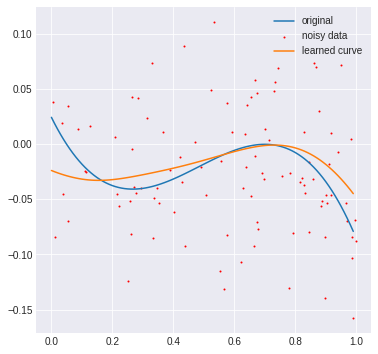

In [ ]:
x_points = np.arange(0, 1, 0.01)
y_points = (0.05 - x_points) * (x_points - 0.7) ** 2 

# generate data
s = np.random.normal(mu, sigma, n_data)
x_data_points = np.random.uniform(size=n_data)
y_data_points = (0.05 - x_data_points) * (x_data_points - 0.7) ** 2 + s

# initialize the net
nn = NeuralNet([1, 30, 30, 1], sigma_type='tanh', lower_norm=1e-4, upper_norm=1e+1)

# train the net
nn.train(x_data_points, y_data_points, adaptive_lr=True, iterations=3e+5)

# evaluate
y_test = np.zeros(len(x_points))
for i in range(len(x_points)):
    y_test[i] = nn.evaluate(x_points[i])

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x_points, y_points, label='original')
ax.scatter(x_data_points, y_data_points, label='noisy data', c='r', s=1)
ax.plot(x_points, y_test, label='learned curve')
ax.legend()

100%|██████████| 100000/100000 [00:32<00:00, 3119.93it/s]


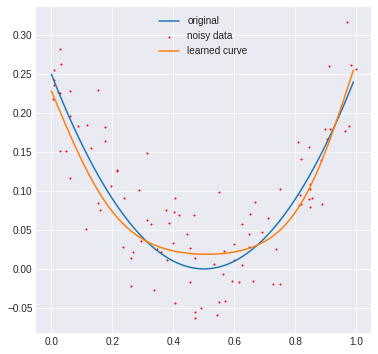

In [ ]:
x_points = np.arange(0, 1, 0.01)
y_points = (x_points - 0.5) ** 2 

# generate data
s = np.random.normal(mu, sigma, n_data)
x_data_points = np.random.uniform(size=n_data)
y_data_points = (x_data_points - 0.5) ** 2 + s

# initialize the net
nn = NeuralNet([1, 30, 1], sigma_type='sigmoid', lower_norm=1e-1, upper_norm=1)

# train the net
nn.train(x_data_points, y_data_points)

# evaluate
y_test = np.zeros(len(x_points))
for i in range(len(x_points)):
    y_test[i] = nn.evaluate(x_points[i])

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x_points, y_points, label='original')
ax.scatter(x_data_points, y_data_points, label='noisy data', c='r', s=1)
ax.plot(x_points, y_test, label='learned curve')
ax.legend()